In [1]:
import pandas as pd
import statsmodels.api as sm

# 1.) Import Data from FRED

In [2]:
data = pd.read_csv("TaylorRuleData.csv", index_col = 0)

In [3]:
data.index = pd.to_datetime(data.index)

In [5]:
data.dropna(inplace=True)

In [6]:
data.head()

,FedFunds,Unemployment,HousingStarts,Inflation
1959-01-01,2.48,6.0,1657.0,29.01
1959-02-01,2.43,5.9,1667.0,29.00
1959-03-01,2.80,5.6,1620.0,28.97
1959-04-01,2.96,5.2,1590.0,28.98
1959-05-01,2.90,5.1,1498.0,29.04


# 2.) Do Not Randomize, split your data into Train, Test Holdout

In [10]:
split_1 = int(len(data)*0.6)
split_2 = int(len(data)*0.9)
data_in = data[:split_1]
data_out = data[split_1:split_2]
data_hold = data[split_2:]

In [20]:
X_in = data_in.iloc[:,1:]
y_in = data_in.iloc[:,0]
X_out = data_out.iloc[:,1:]
y_out = data_out.iloc[:,0]
X_hold = data_hold.iloc[:,1:]
y_hold = data_hold.iloc[:,0]

In [21]:
# Add Constants
X_in = sm.add_constant(X_in)
X_out = sm.add_constant(X_out) 
X_hold = sm.add_constant(X_hold)

# 3.) Build a model that regresses FF~Unemp, HousingStarts, Inflation

In [15]:
model1 = sm.OLS(y_in, X_in).fit()

In [17]:
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:               FedFunds   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     14.83
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           3.09e-09
Time:                        14:51:53   Log-Likelihood:                -1202.0
No. Observations:                 467   AIC:                             2412.
Df Residuals:                     463   BIC:                             2429.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.4750      0.985      3.529

# 4.) Recreate the graph fro your model

In [16]:
import matplotlib.pyplot as plt

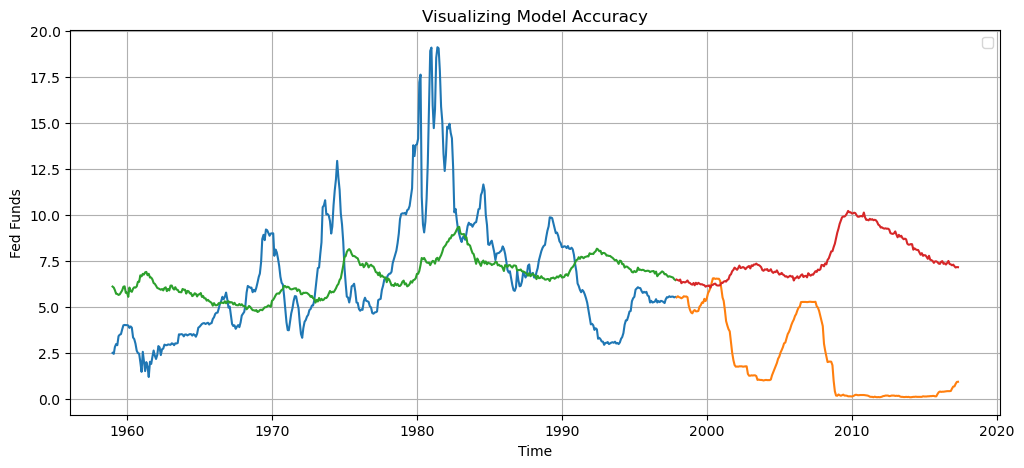

In [22]:
plt.figure(figsize = (12,5))

###
plt.plot(y_in)
plt.plot(y_out)
plt.plot(model1.predict(X_in))
plt.plot(model1.predict(X_out))
###


plt.ylabel("Fed Funds")
plt.xlabel("Time")
plt.title("Visualizing Model Accuracy")
plt.legend([])
plt.grid()
plt.show()

## "All Models are wrong but some are useful" - 1976 George Box

# 5.) What are the in/out of sample MSEs

In [24]:
from sklearn.metrics import mean_squared_error

In [25]:
in_mse_1 = mean_squared_error(model1.predict(X_in),y_in)
out_mse_1 = mean_squared_error(model1.predict(X_out),y_out)

In [26]:
print("Insample MSE : ", in_mse_1)
print("Outsample MSE : ", out_mse_1)

Insample MSE :  10.071422013168643
Outsample MSE :  40.3608278356685


# 6.) Using a for loop. Repeat 3,4,5 for polynomial degrees 1,2,3

In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [29]:
degrees=2

In [30]:
poly=PolynomialFeatures(degree=degrees)
X_in_poly=poly.fit_transform(X_in)
X_out_poly=poly.fit_transform(X_out)

DEGREE:  1


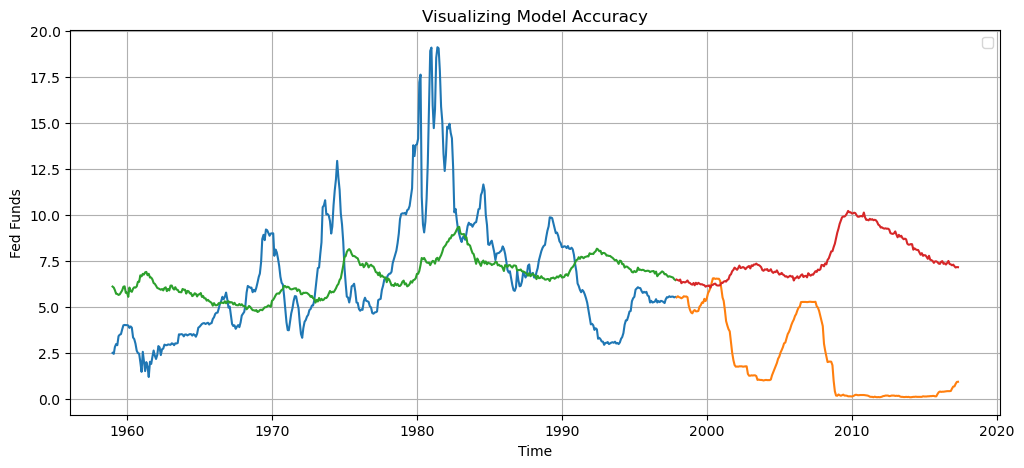

Insample MSE :  10.071422013168641
Outsample MSE :  40.3608278356651
DEGREE:  2


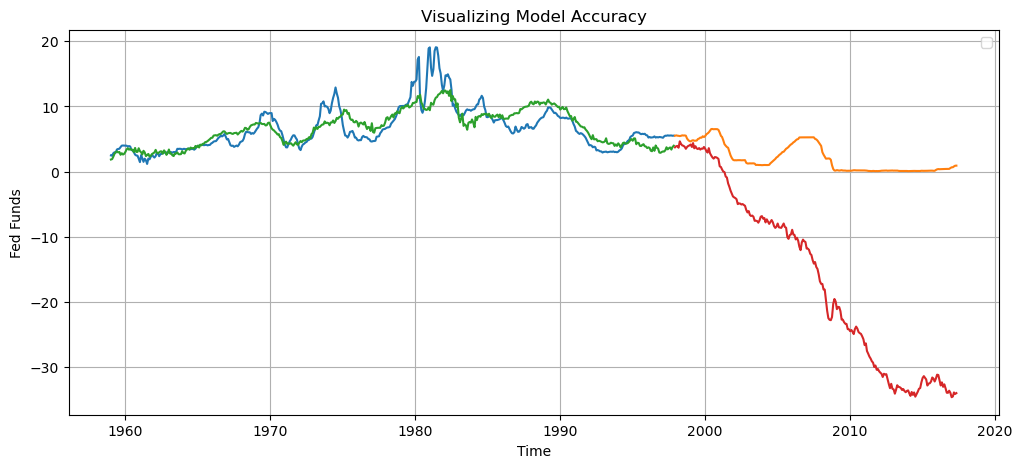

Insample MSE :  3.863477139276068
Outsample MSE :  481.44650989519766
DEGREE:  3


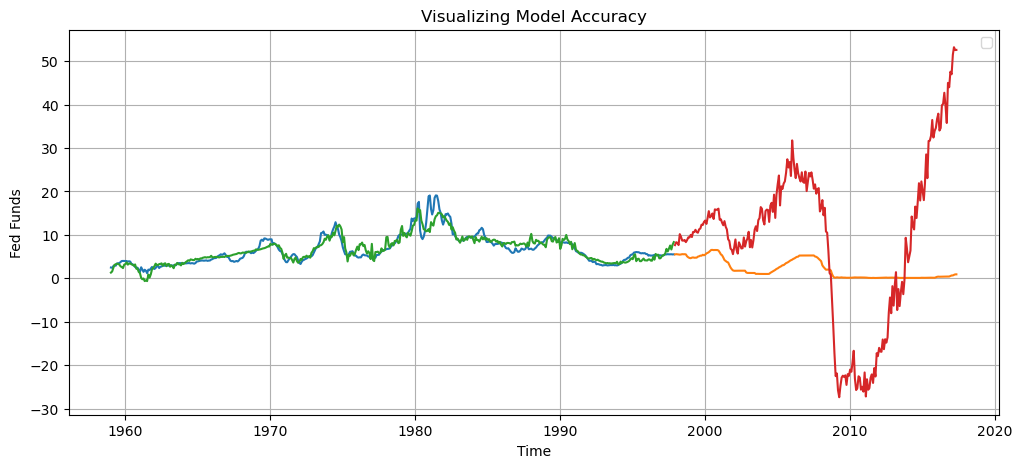

Insample MSE :  1.8723636265485022
Outsample MSE :  371.7679629693228


In [41]:
for degree in range(1,4,1):
    print("DEGREE: ",degree)
    poly = PolynomialFeatures(degree=degree)
    X_in_poly=poly.fit_transform(X_in)
    X_out_poly=poly.fit_transform(X_out)

    # Fit the model
    poly_model = LinearRegression()
    poly_model.fit(X_in_poly, y_in)
    
    in_preds= poly_model.predict(X_in_poly)
    in_preds=pd.DataFrame(in_preds,index=y_in.index)
    out_preds= poly_model.predict(X_out_poly)
    out_preds=pd.DataFrame(out_preds,index=y_out.index)

    plt.figure(figsize = (12,5))


    plt.plot(y_in)
    plt.plot(y_out)
    plt.plot(in_preds)
    plt.plot(out_preds)

    plt.ylabel("Fed Funds")
    plt.xlabel("Time")
    plt.title("Visualizing Model Accuracy")
    plt.legend([])
    plt.grid()
    plt.show()
    
    in_mse_1 = mean_squared_error(poly_model.predict(X_in_poly),y_in)
    out_mse_1 = mean_squared_error(poly_model.predict(X_out_poly),y_out)
    
    print("Insample MSE : ", in_mse_1)
    print("Outsample MSE : ", out_mse_1)

# 7.) State your observations :

When we increase the polynomial degree, insample MSE decreases, while outsample MSE firstly increases and then decreases a little bit. To be more specific, the linear model seems to be under-fitted, while square and cubic ones seem to be over-fitted. Thus, we fit more noise than trend in model 2 and 3. We face a tradeoff here. If we increase the polynomial degree, the model will fit better in training sample, but it will be more likely to fit some unnecessary noise. We need to use the validation set to balance between that.